# KNN Book recommendation

The Objective of this notebook will be to explore the data sets and then create a model to recommend book<br> stores what books to stock up on depending on the bookstore's location and the demographic(age) of that location.

## Setup Environment

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD


In [3]:
path = os.path.join(os.path.normpath(os.getcwd() + os.sep + os.pardir) + "/data/cleaned")

In [4]:
cwd = os.path.join(os.path.normpath(os.getcwd() + os.sep + os.pardir))

In [5]:
os.listdir(path)

['BX-Books.csv', 'BX-NewBooksRatings.csv', 'BX-Ratings.csv', 'Bx-Users.csv']

#### Read in clean data

In [6]:
ratings = pd.read_csv(path + '/BX-Ratings.csv')
print(ratings.dtypes)
ratings.head()

User-ID         int64
ISBN           object
Book-Rating     int64
dtype: object


,User-ID,ISBN,Book-Rating
0,276744,038550120X,7
1,276754,0684867621,8
2,276755,0451166892,5
3,276762,0380711524,5
4,276772,0553572369,7


In [7]:
users = pd.read_csv(path + '/BX-Users.csv')
print(users.dtypes)
users.head()

Unnamed: 0        int64
User-ID           int64
User-City        object
User-State       object
User-Country     object
User-Age        float64
dtype: object


,Unnamed: 0,User-ID,User-City,User-State,User-Country,User-Age
0,0,8,timmins,ontario,canada,35.411561
1,1,9,germantown,tennessee,usa,37.603524
2,2,16,albuquerque,new mexico,usa,37.603524
3,3,17,chesapeake,virginia,usa,37.603524
4,4,19,weston,florida,usa,14.000000


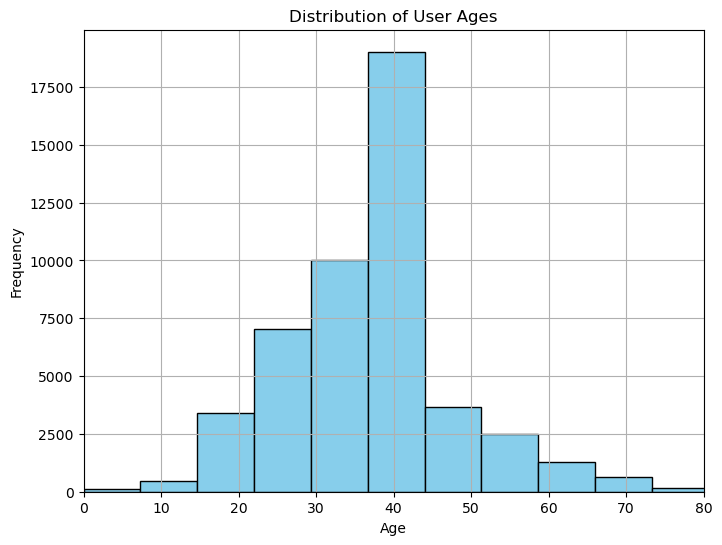

In [8]:
plt.figure(figsize=(8, 6))
plt.hist(users['User-Age'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of User Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.xlim(0,80)
plt.grid(True)
plt.show()

In [9]:
books = pd.read_csv(path + '/BX-Books.csv')
print(books.dtypes)
books.head()

ISBN                      object
Book-Title                object
Book-Author               object
Year-Of-Publication      float64
Book-Publisher            object
Book-Author-Processed     object
dtype: object


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed
0,0002005018,Clara Callan,richard bruce wright,2001.0,harperflamingo canada,richard bruce wright
1,0374157065,Flu: The Story of the Great Influenza Pandemic...,gina bari kolata,1999.0,farrar straus giroux,gina bari kolata
2,0399135782,The Kitchen God's Wife,amy tan,1991.0,putnam pub group,amy tan
3,0440234743,The Testament,john grisham,1999.0,dell,john grisham
4,0452264464,Beloved (Plume Contemporary Fiction),toni morrison,1994.0,plume,toni morrison


We should only use ratings that are of books in our data set of books

In [10]:
ratings_new = ratings[ratings.ISBN.isin(books.ISBN)]
ratings.shape,ratings_new.shape

((204164, 3), (204164, 3))

Both ratings and ratings_new have the same shape so we can assume that all the ratings are of books in our books data set.<br>
Thats great!

Now our ratings need to be from users in our user data set

In [11]:
print("Shape of dataset before dropping",ratings_new.shape)
ratings_new = ratings_new[ratings_new['User-ID'].isin(users['User-ID'])]
print("shape of dataset after dropping",ratings_new.shape)

Shape of dataset before dropping (204164, 3)
shape of dataset after dropping (204164, 3)


Okay so all the ratings we got have their corrosponding user data, nice!

#### Analyse rating distribution

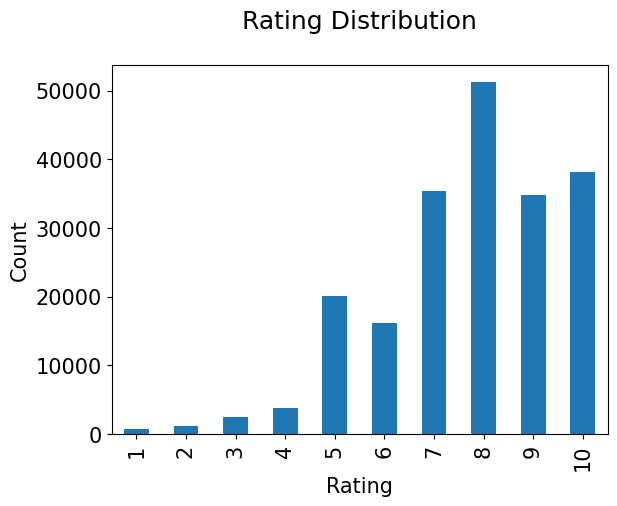

In [12]:
ratings_counts = ratings['Book-Rating'].value_counts(sort=False)

ratings_counts_sorted = ratings_counts.sort_index()

plt.rc("font", size=15)
ratings_counts_sorted.plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

It seems that the ratings are very heavily negatively skewed, this means that people will generally review books they like rather than books the don't like more often

Let's take a look at the top 5 books that have been rated the most by users

In [13]:
rating_count = pd.DataFrame(ratings.groupby('ISBN')['Book-Rating'].count())
rating_count.sort_values('Book-Rating', ascending=False).head()

,Book-Rating
ISBN,
0316666343,675
0971880107,575
0385504209,479
0312195516,362
0060928336,312


In [14]:
most_rated_books = pd.DataFrame(['0316666343', '0971880107', '0385504209', '0312195516', '0060928336'], index=np.arange(5), columns = ['ISBN'])
most_rated_books_summary = pd.merge(most_rated_books, books, on='ISBN')
most_rated_books_summary

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed
0,0316666343,The Lovely Bones: A Novel,alice sebold,2002.0,little brown,alice sebold
1,0971880107,Wild Animus,rich shapero,2004.0,too far,rich shapero
2,0385504209,The Da Vinci Code,dan brown,2003.0,doubleday,dan brown
3,0312195516,The Red Tent (Bestselling Backlist),anita diamant,1998.0,picador usa,anita diamant
4,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,rebecca wells,1997.0,perennial,rebecca well


Just for intuition let's see the distribution of ratings for the top book: "The Lovely Bones: A Novel"

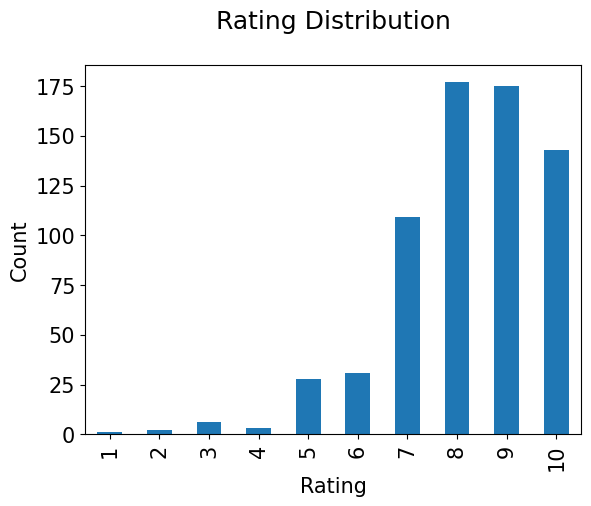

In [15]:
isbn_0316666343_df = ratings[ratings['ISBN'] == '0316666343']

isbn_0316666343_df_counts = isbn_0316666343_df['Book-Rating'].value_counts(sort=False)

isbn_0316666343_df_sorted = isbn_0316666343_df_counts.sort_index()

plt.rc("font", size=15)
isbn_0316666343_df_sorted.plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

It seems that the same trends still hold thats great!

Now let's create a new collumn in our ratings df for average rating of that book

In [16]:
# Create column Rating average 
ratings['Avg_Rating']=ratings.groupby('ISBN')['Book-Rating'].transform('mean')
# Create column Rating sum
ratings['Times been Rated']=ratings.groupby('ISBN')['Book-Rating'].transform('count')

In [17]:
ratings.head()

,User-ID,ISBN,Book-Rating,Avg_Rating,Times been Rated
0,276744,038550120X,7,7.569620,79
1,276754,0684867621,8,7.103448,58
2,276755,0451166892,5,8.383721,86
3,276762,0380711524,5,7.625000,16
4,276772,0553572369,7,6.625000,8


Okay now let's merge the data sets together for further analysis

In [18]:

Final_Dataset=users.copy()
Final_Dataset=pd.merge(Final_Dataset,ratings,on='User-ID')
Final_Dataset=pd.merge(Final_Dataset,books,on='ISBN')
Final_Dataset = Final_Dataset.drop(['Unnamed: 0'], axis=1)


In [19]:
Final_Dataset.head()

,User-ID,User-City,User-State,User-Country,User-Age,ISBN,Book-Rating,Avg_Rating,Times been Rated,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed
0,8,timmins,ontario,canada,35.411561,0002005018,5,7.5,8,Clara Callan,richard bruce wright,2001.0,harperflamingo canada,richard bruce wright
1,11676,NaN,NaN,NaN,36.204178,0002005018,8,7.5,8,Clara Callan,richard bruce wright,2001.0,harperflamingo canada,richard bruce wright
2,67544,toronto,ontario,canada,30.000000,0002005018,8,7.5,8,Clara Callan,richard bruce wright,2001.0,harperflamingo canada,richard bruce wright
3,123629,kingston,ontario,canada,35.411561,0002005018,9,7.5,8,Clara Callan,richard bruce wright,2001.0,harperflamingo canada,richard bruce wright
4,200273,comber,ontario,canada,35.411561,0002005018,8,7.5,8,Clara Callan,richard bruce wright,2001.0,harperflamingo canada,richard bruce wright


In [20]:
missing_values_count = Final_Dataset.isna().sum()
total_values = len(Final_Dataset)

# Calculate the percentage of missing values for each column
missing_values_percentage = (missing_values_count / total_values) * 100

# Creating a new DataFrame to store the missing values count and percentage
missing_values_df = pd.DataFrame({'Column': missing_values_count.index, 
                                  'Missing Values': missing_values_count.values,
                                  'Missing Values (%)': missing_values_percentage.values})

missing_values_df

,Column,Missing Values,Missing Values (%)
0,User-ID,0,0.000000
1,User-City,4743,2.323132
2,User-State,4159,2.037088
3,User-Country,3620,1.773084
4,User-Age,0,0.000000
5,ISBN,0,0.000000
6,Book-Rating,0,0.000000
7,Avg_Rating,0,0.000000
8,Times been Rated,0,0.000000
9,Book-Title,0,0.000000


It seems that there are a lot of missing values in the location collumns. Since we are trying to train our model to give recommendations based on location, I think that we should omit these rows

In [21]:
Final_Dataset.dropna(inplace=True)
missing_values_count = Final_Dataset.isna().sum()
total_values = len(Final_Dataset)

# Calculate the percentage of missing values for each column
missing_values_percentage = (missing_values_count / total_values) * 100

# Creating a new DataFrame to store the missing values count and percentage
missing_values_df = pd.DataFrame({'Column': missing_values_count.index, 
                                  'Missing Values': missing_values_count.values,
                                  'Missing Values (%)': missing_values_percentage.values})

missing_values_df


,Column,Missing Values,Missing Values (%)
0,User-ID,0,0.0
1,User-City,0,0.0
2,User-State,0,0.0
3,User-Country,0,0.0
4,User-Age,0,0.0
5,ISBN,0,0.0
6,Book-Rating,0,0.0
7,Avg_Rating,0,0.0
8,Times been Rated,0,0.0
9,Book-Title,0,0.0


### Categorising by age and location

If we want to help bookstore owners pick new books to purchase for their store, we need to find out what books the people in that area like. We will take an approach that makes artificial users which will be a collation separated by area and age. Then we will feed this into a model that can tell us what type of books to recommend to this demographic

Location Categorisation

Let's see how the locations are distributed to get a feel on how to categorise location

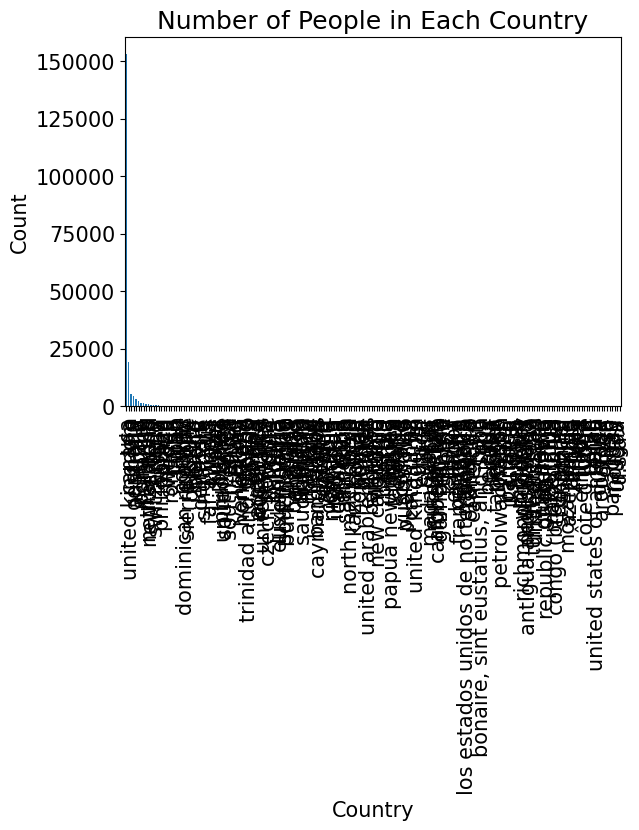

In [22]:
country_counts = Final_Dataset['User-Country'].value_counts()

# Plotting the results
country_counts.plot(kind='bar')
plt.title('Number of People in Each Country')
plt.xlabel('Country')
plt.ylabel('Count')
plt.show()

While this doesn't tell us much, it's clear there are a few countries with far greater number of users. It wouldn't be apprpriate to group all these users together.
So, we shall then reduce the scale for these countreis into states or cities. Lets first find out which cities are the greatest and least.

In [23]:
country_counts.head(10)

User-Country
usa               152978
canada             19187
united kingdom      5531
germany             4448
australia           2979
spain               2293
portugal            1628
france              1420
malaysia            1078
netherlands          878
Name: count, dtype: int64

In [24]:
print(len(country_counts))
country_counts.tail(10)

198


User-Country
united states of america    1
guyana                      1
aroostook                   1
oman                        1
ysa                         1
kern                        1
paraguay                    1
morgan                      1
urugua                      1
u.s.a>                      1
Name: count, dtype: int64

Firstly there are alot of countries with only one user and this won't be enough to get an idea of what kind of books that country/demographic enjoy. We will omit these countries in our data set training 

In [25]:

country_counts_df = Final_Dataset.groupby('User-Country').size()

# Filter countries with 5 or less users
countries_to_drop = country_counts_df[country_counts <= 5].index
rows_to_drop = Final_Dataset[Final_Dataset['User-Country'].isin(countries_to_drop)].index
Final_Dataset = Final_Dataset.drop(rows_to_drop)

#Recount
country_counts = Final_Dataset['User-Country'].value_counts()
print(len(country_counts[(country_counts > 5) & (country_counts < 30)]))
country_counts.tail(10)



36


User-Country
laos              7
algeria           7
cayman islands    7
bangladesh        7
thailand          7
czechia           7
nicaragua         6
van wert          6
colombia          6
slovakia          6
Name: count, dtype: int64

We will categorize via this method:<br>
If the country has less than 30 users we group by country.<br>
for countries with between 30 to 200 users we will group by state.<br>
for countries with 200 to 500 users we will group by city.<br>
for countries with >500 we will group by city then by categorical age(young, middle, old.)<br>

The objective is to get roughly the same number of users and reviews in each section such that the range of books is not too wide

In [26]:
countries_lt_30_list = country_counts[country_counts < 30].index
countries_30_200_list =  country_counts[(country_counts>=30) & (country_counts <200)].index
countries_200_500_list = country_counts[(country_counts>=200) & (country_counts<500)].index
countries_gt_500_list = country_counts[(country_counts>500)].index

In [27]:
df_30 = Final_Dataset[Final_Dataset['User-Country'].isin(countries_lt_30_list)]
df_30_200 = Final_Dataset[Final_Dataset['User-Country'].isin(countries_30_200_list)]
df_200_500 = Final_Dataset[Final_Dataset['User-Country'].isin(countries_200_500_list)]
df_500 = Final_Dataset[Final_Dataset['User-Country'].isin(countries_gt_500_list)]

In [28]:
df_30

,User-ID,User-City,User-State,User-Country,User-Age,ISBN,Book-Rating,Avg_Rating,Times been Rated,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed
1087,33179,freedonia,emilia romagna,antarctica,36.204178,0451166892,10,8.383721,86,The Pillars of the Earth,ken follett,1996.0,signet books,ken follett
1351,4098,mei foo,kowloon,hong kong,30.000000,0671027360,7,8.075758,264,Angels & Demons,dan brown,2001.0,pocket star,dan brown
1467,131510,luxembourg,_,luxembourg,31.000000,0671027360,5,8.075758,264,Angels & Demons,dan brown,2001.0,pocket star,dan brown
2090,230003,taipei,taipei,taiwan,25.000000,0385337639,6,8.307692,26,Crow Lake (Today Show Book Club #7),mary lawson,2003.0,delta,mary lawson
2146,242,neuffen,chattogram,bangladesh,37.000000,0553278223,10,8.555556,27,The Martian Chronicles,ray bradbury,1984.0,spectra,ray bradbury
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201859,191037,buenos aires,capital federal,argentina,28.600000,8445073028,8,8.200000,5,"Naranja Mecanica, La",anthony burgess,1999.0,minotauro,anthony burgess
201882,260324,goteborg,jonglei,south sudan,31.000000,0553260456,9,9.000000,4,Fire Watch,connie willis,1998.0,spectra books,connie willis
203418,209220,virginia beach,virginia,united states,52.000000,0373227094,8,7.750000,4,"Defending The Heiress (Heros,Inc.)",susan kearney,2003.0,harlequin,susan kearney
203688,174479,zahna,oran,algeria,21.000000,3518388762,10,8.000000,4,Besessen,a s byatt,1994.0,intl book import service,byatt


In [29]:
countries = df_30['User-Country']
new_ids_30 = countries + '-Na-Na-Na'
df_30['User-ID'] = new_ids_30

df_30


C:\Users\Justin\AppData\Local\Temp\ipykernel_1276\1168025851.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_30['User-ID'] = new_ids_30


,User-ID,User-City,User-State,User-Country,User-Age,ISBN,Book-Rating,Avg_Rating,Times been Rated,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed
1087,antarctica-Na-Na-Na,freedonia,emilia romagna,antarctica,36.204178,0451166892,10,8.383721,86,The Pillars of the Earth,ken follett,1996.0,signet books,ken follett
1351,hong kong-Na-Na-Na,mei foo,kowloon,hong kong,30.000000,0671027360,7,8.075758,264,Angels & Demons,dan brown,2001.0,pocket star,dan brown
1467,luxembourg-Na-Na-Na,luxembourg,_,luxembourg,31.000000,0671027360,5,8.075758,264,Angels & Demons,dan brown,2001.0,pocket star,dan brown
2090,taiwan-Na-Na-Na,taipei,taipei,taiwan,25.000000,0385337639,6,8.307692,26,Crow Lake (Today Show Book Club #7),mary lawson,2003.0,delta,mary lawson
2146,bangladesh-Na-Na-Na,neuffen,chattogram,bangladesh,37.000000,0553278223,10,8.555556,27,The Martian Chronicles,ray bradbury,1984.0,spectra,ray bradbury
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201859,argentina-Na-Na-Na,buenos aires,capital federal,argentina,28.600000,8445073028,8,8.200000,5,"Naranja Mecanica, La",anthony burgess,1999.0,minotauro,anthony burgess
201882,south sudan-Na-Na-Na,goteborg,jonglei,south sudan,31.000000,0553260456,9,9.000000,4,Fire Watch,connie willis,1998.0,spectra books,connie willis
203418,united states-Na-Na-Na,virginia beach,virginia,united states,52.000000,0373227094,8,7.750000,4,"Defending The Heiress (Heros,Inc.)",susan kearney,2003.0,harlequin,susan kearney
203688,algeria-Na-Na-Na,zahna,oran,algeria,21.000000,3518388762,10,8.000000,4,Besessen,a s byatt,1994.0,intl book import service,byatt


In [30]:
countries = df_30_200['User-Country']
states = df_30_200['User-State']
new_ids_30_200 = countries + '-'+ states +'-Na-Na'
df_30_200['User-ID'] = new_ids_30_200

df_30_200

C:\Users\Justin\AppData\Local\Temp\ipykernel_1276\473220025.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_30_200['User-ID'] = new_ids_30_200


,User-ID,User-City,User-State,User-Country,User-Age,ISBN,Book-Rating,Avg_Rating,Times been Rated,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed
163,iran-tehran-Na-Na,tehran,tehran,iran,36.000000,0425099148,9,8.666667,6,Death in the Clouds,agatha christie,1997.0,berkley publishing group,agatha christie
243,singapore-singapore-Na-Na,singapore,singapore,singapore,22.000000,0446310786,10,8.946078,204,To Kill a Mockingbird,harper lee,1988.0,little brown and company,harper lee
554,us-hawaii-Na-Na,waianae,hawaii,us,36.204178,0060168013,10,8.380952,21,Pigs in Heaven,barbara kingsolver,1993.0,harpercollins,barbara kingsolver
976,kuwait-kuwait-Na-Na,kuwait,kuwait,kuwait,17.000000,0671867156,10,8.113208,53,Pretend You Don't See Her,mary higgins clark,1998.0,pocket,mary higgins clark
1378,egypt-cairo-Na-Na,maadi,cairo,egypt,33.000000,0671027360,7,8.075758,264,Angels & Demons,dan brown,2001.0,pocket star,dan brown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203596,dominican republic-distrito nacional-Na-Na,santo domingo,distrito nacional,dominican republic,30.000000,0373484046,10,7.750000,4,Soldiers Of Fortune,diana palmer,2000.0,silhouette,diana palmer
203600,dominican republic-distrito nacional-Na-Na,santo domingo,distrito nacional,dominican republic,30.000000,0373484461,10,9.500000,4,"Long, Tall Texans (Calhoun, Justin, and Tyler)",diana palmer,2001.0,silhouette,diana palmer
203604,dominican republic-distrito nacional-Na-Na,santo domingo,distrito nacional,dominican republic,30.000000,1551665395,10,7.750000,4,Paper Rose,diana palmer,1999.0,mira,diana palmer
203807,dominican republic-distrito nacional-Na-Na,santo domingo,distrito nacional,dominican republic,30.000000,0380776162,10,9.000000,5,Lord of Scoundrels,loretta chase,1995.0,avon,loretta chase


In [31]:
countries = df_200_500['User-Country']
states = df_200_500['User-State']
cities = df_200_500['User-City']
new_ids_200_500 = countries + '-'+ states +'-' + cities + '-Na'
df_200_500['User-ID'] = new_ids_200_500

df_200_500

C:\Users\Justin\AppData\Local\Temp\ipykernel_1276\992839114.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_200_500['User-ID'] = new_ids_200_500


,User-ID,User-City,User-State,User-Country,User-Age,ISBN,Book-Rating,Avg_Rating,Times been Rated,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed
262,austria-vienna-vienna-Na,vienna,vienna,austria,18.00000,0446310786,8,8.946078,204,To Kill a Mockingbird,harper lee,1988.0,little brown and company,harper lee
274,philippines-makati-makati-Na,makati,makati,philippines,28.00000,0446310786,10,8.946078,204,To Kill a Mockingbird,harper lee,1988.0,little brown and company,harper lee
380,philippines-albay-legazpi-Na,legazpi,albay,philippines,23.00000,0446310786,7,8.946078,204,To Kill a Mockingbird,harper lee,1988.0,little brown and company,harper lee
1032,finland-uusimaa-kerava-Na,kerava,uusimaa,finland,58.00000,0316748641,8,6.800000,5,Pasquale's Nose: Idle Days in an Italian Town,michael rips,2002.0,back bay books,michael rip
1279,philippines-albay-legazpi-Na,legazpi,albay,philippines,23.00000,0446612545,9,7.831683,101,The Beach House,james patterson,2003.0,warner books,james patterson
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203419,brazil-são paulo-são paulo-Na,são paulo,são paulo,brazil,46.00000,0345374266,6,7.400000,5,Shadows in Bronze,lindsey davis,1993.0,ballantine books,lindsey davis
203754,romania-vaslui-barlad-Na,barlad,vaslui,romania,25.00000,1567184464,10,10.000000,4,The Craft: A Witch's Book of Shadows,dorothy morrison,2001.0,llewellyn publications,dorothy morrison
203765,sweden-skåne-malmok-Na,malmok,skåne,sweden,28.28125,0316781460,8,7.833333,6,Live from New York: An Uncensored History of S...,tom shales,2002.0,little brown,tom shale
204006,sweden-stockholm-stockholm-Na,stockholm,stockholm,sweden,31.00000,3423118709,8,8.800000,5,Title Kassandra. ErzÃ?ÃÂ¤hlung. ( Sammlung L...,christa wolf,1993.0,dtv,christa wolf


Now for age grouping we need to find a way to separate the different ages, lets do some quick analysis for the ages

In [32]:
percentile_33 = np.percentile(Final_Dataset['User-Age'], 18)

percentile_66 = np.percentile(Final_Dataset['User-Age'], 82)

print("33rd percentile of age:", percentile_33)
print("66th percentile of age:", percentile_66)

33rd percentile of age: 28.0
66th percentile of age: 44.0


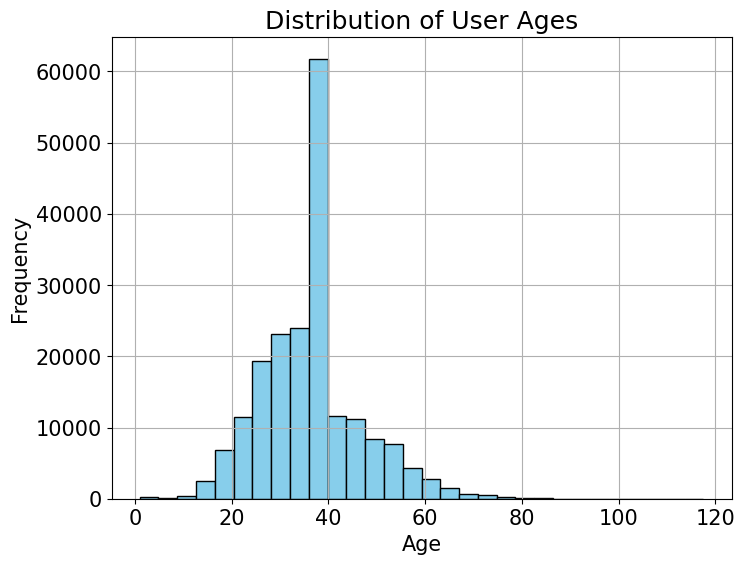

In [33]:
plt.figure(figsize=(8, 6))
plt.hist(Final_Dataset['User-Age'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of User Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The distribution for age is approximately normally distributed, so let's split the distribution into three parts:<br>

1. young people 0 - 28
2. middle aged 29 - 43
3. Old 44 - &infin;

In [34]:
age_bins = [0, 28, 43, np.inf]
age_labels = ['Young', 'Middle-aged', 'Old']
df_500['Age-Category'] = pd.cut(df_500['User-Age'], bins=age_bins, labels=age_labels, right=False)
df_500['Age-Category'] = df_500['Age-Category'].astype('object')

df_500

C:\Users\Justin\AppData\Local\Temp\ipykernel_1276\2987618089.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_500['Age-Category'] = pd.cut(df_500['User-Age'], bins=age_bins, labels=age_labels, right=False)
C:\Users\Justin\AppData\Local\Temp\ipykernel_1276\2987618089.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_500['Age-Category'] = df_500['Age-Category'].astype('object')


,User-ID,User-City,User-State,User-Country,User-Age,ISBN,Book-Rating,Avg_Rating,Times been Rated,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed,Age-Category
0,8,timmins,ontario,canada,35.411561,0002005018,5,7.5,8,Clara Callan,richard bruce wright,2001.0,harperflamingo canada,richard bruce wright,Middle-aged
2,67544,toronto,ontario,canada,30.000000,0002005018,8,7.5,8,Clara Callan,richard bruce wright,2001.0,harperflamingo canada,richard bruce wright,Middle-aged
3,123629,kingston,ontario,canada,35.411561,0002005018,9,7.5,8,Clara Callan,richard bruce wright,2001.0,harperflamingo canada,richard bruce wright,Middle-aged
4,200273,comber,ontario,canada,35.411561,0002005018,8,7.5,8,Clara Callan,richard bruce wright,2001.0,harperflamingo canada,richard bruce wright,Middle-aged
5,210926,guelph,ontario,canada,35.411561,0002005018,9,7.5,8,Clara Callan,richard bruce wright,2001.0,harperflamingo canada,richard bruce wright,Middle-aged
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204159,265784,san jose,california,usa,37.603524,0886775809,7,8.0,4,"The Law of Becoming (Jaran, Book 4)",kate elliott,1994.0,daw books,kate elliott,Middle-aged
204160,246196,euclid,ohio,usa,24.000000,0375700110,4,6.5,4,Half and Half: Writers on Growing Up Biracial ...,claudine c ohearn,1998.0,pantheon books,claudine c ohearn,Young
204161,257485,santa clara,california,usa,24.000000,0375700110,6,6.5,4,Half and Half: Writers on Growing Up Biracial ...,claudine c ohearn,1998.0,pantheon books,claudine c ohearn,Young
204162,274666,ypsilanti,michigan,usa,37.603524,0375700110,9,6.5,4,Half and Half: Writers on Growing Up Biracial ...,claudine c ohearn,1998.0,pantheon books,claudine c ohearn,Middle-aged


In [35]:
countries = df_500['User-Country']
states = df_500['User-State']
cities = df_500['User-City']
age = df_500['Age-Category']
new_ids_500 = countries + '-'+ states +'-' + cities + '-' + age
df_500['User-ID'] = new_ids_500

df_500

C:\Users\Justin\AppData\Local\Temp\ipykernel_1276\1997005402.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_500['User-ID'] = new_ids_500


,User-ID,User-City,User-State,User-Country,User-Age,ISBN,Book-Rating,Avg_Rating,Times been Rated,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed,Age-Category
0,canada-ontario-timmins-Middle-aged,timmins,ontario,canada,35.411561,0002005018,5,7.5,8,Clara Callan,richard bruce wright,2001.0,harperflamingo canada,richard bruce wright,Middle-aged
2,canada-ontario-toronto-Middle-aged,toronto,ontario,canada,30.000000,0002005018,8,7.5,8,Clara Callan,richard bruce wright,2001.0,harperflamingo canada,richard bruce wright,Middle-aged
3,canada-ontario-kingston-Middle-aged,kingston,ontario,canada,35.411561,0002005018,9,7.5,8,Clara Callan,richard bruce wright,2001.0,harperflamingo canada,richard bruce wright,Middle-aged
4,canada-ontario-comber-Middle-aged,comber,ontario,canada,35.411561,0002005018,8,7.5,8,Clara Callan,richard bruce wright,2001.0,harperflamingo canada,richard bruce wright,Middle-aged
5,canada-ontario-guelph-Middle-aged,guelph,ontario,canada,35.411561,0002005018,9,7.5,8,Clara Callan,richard bruce wright,2001.0,harperflamingo canada,richard bruce wright,Middle-aged
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204159,usa-california-san jose-Middle-aged,san jose,california,usa,37.603524,0886775809,7,8.0,4,"The Law of Becoming (Jaran, Book 4)",kate elliott,1994.0,daw books,kate elliott,Middle-aged
204160,usa-ohio-euclid-Young,euclid,ohio,usa,24.000000,0375700110,4,6.5,4,Half and Half: Writers on Growing Up Biracial ...,claudine c ohearn,1998.0,pantheon books,claudine c ohearn,Young
204161,usa-california-santa clara-Young,santa clara,california,usa,24.000000,0375700110,6,6.5,4,Half and Half: Writers on Growing Up Biracial ...,claudine c ohearn,1998.0,pantheon books,claudine c ohearn,Young
204162,usa-michigan-ypsilanti-Middle-aged,ypsilanti,michigan,usa,37.603524,0375700110,9,6.5,4,Half and Half: Writers on Growing Up Biracial ...,claudine c ohearn,1998.0,pantheon books,claudine c ohearn,Middle-aged


In [36]:
demographic_final_data = pd.concat([df_30, df_30_200, df_200_500, df_500], ignore_index=True)
demographic_final_data.rename(columns={'User-ID': 'demographic'}, inplace=True)

demographic_final_data

,demographic,User-City,User-State,User-Country,User-Age,ISBN,Book-Rating,Avg_Rating,Times been Rated,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed,Age-Category
0,antarctica-Na-Na-Na,freedonia,emilia romagna,antarctica,36.204178,0451166892,10,8.383721,86,The Pillars of the Earth,ken follett,1996.0,signet books,ken follett,NaN
1,hong kong-Na-Na-Na,mei foo,kowloon,hong kong,30.000000,0671027360,7,8.075758,264,Angels & Demons,dan brown,2001.0,pocket star,dan brown,NaN
2,luxembourg-Na-Na-Na,luxembourg,_,luxembourg,31.000000,0671027360,5,8.075758,264,Angels & Demons,dan brown,2001.0,pocket star,dan brown,NaN
3,taiwan-Na-Na-Na,taipei,taipei,taiwan,25.000000,0385337639,6,8.307692,26,Crow Lake (Today Show Book Club #7),mary lawson,2003.0,delta,mary lawson,NaN
4,bangladesh-Na-Na-Na,neuffen,chattogram,bangladesh,37.000000,0553278223,10,8.555556,27,The Martian Chronicles,ray bradbury,1984.0,spectra,ray bradbury,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198935,usa-california-san jose-Middle-aged,san jose,california,usa,37.603524,0886775809,7,8.000000,4,"The Law of Becoming (Jaran, Book 4)",kate elliott,1994.0,daw books,kate elliott,Middle-aged
198936,usa-ohio-euclid-Young,euclid,ohio,usa,24.000000,0375700110,4,6.500000,4,Half and Half: Writers on Growing Up Biracial ...,claudine c ohearn,1998.0,pantheon books,claudine c ohearn,Young
198937,usa-california-santa clara-Young,santa clara,california,usa,24.000000,0375700110,6,6.500000,4,Half and Half: Writers on Growing Up Biracial ...,claudine c ohearn,1998.0,pantheon books,claudine c ohearn,Young
198938,usa-michigan-ypsilanti-Middle-aged,ypsilanti,michigan,usa,37.603524,0375700110,9,6.500000,4,Half and Half: Writers on Growing Up Biracial ...,claudine c ohearn,1998.0,pantheon books,claudine c ohearn,Middle-aged


In [37]:
user_id_counts = demographic_final_data.groupby('demographic').size()
print(len(user_id_counts))

16955


Nice, so now we have the same dataframe, but this has in terms of the demographic which will be more useful for bookstores and booksellers

## Book recommendation system

This section we will try and transform the data to make KNN more plausible


In [38]:
ratings.head()

,User-ID,ISBN,Book-Rating,Avg_Rating,Times been Rated
0,276744,038550120X,7,7.569620,79
1,276754,0684867621,8,7.103448,58
2,276755,0451166892,5,8.383721,86
3,276762,0380711524,5,7.625000,16
4,276772,0553572369,7,6.625000,8


### Implementing Knn

Let's make a matrix of ratings and books to see what books get ratings from similar users

In [39]:
ratings_matrix = ratings.pivot(index='User-ID', columns='ISBN', values='Book-Rating')
userID = ratings_matrix.index
ISBN = ratings_matrix.columns
print(ratings_matrix.shape)
ratings_matrix.head()

(48299, 18185)


ISBN,0002005018,0002116286,0002243962,0002251760,0002255081,0002259834,0002261820,0002550563,0002558122,0003300277,...,9681500954,968150108X,9681501225,9722016563,972210277X,9722105248,9726101794,9728423160,9812327975,9871138148
User-ID,,,,,,,,,,,,,,,,,,,,,
8,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
n_users = ratings_matrix.shape[0]
n_books = ratings_matrix.shape[1]
print (n_users, n_books)
     

48299 18185


Let's fix up those nans

In [41]:
ratings_matrix.fillna(0, inplace = True)
ratings_matrix = ratings_matrix.astype(np.int32)

In [42]:
ratings_matrix

ISBN,0002005018,0002116286,0002243962,0002251760,0002255081,0002259834,0002261820,0002550563,0002558122,0003300277,...,9681500954,968150108X,9681501225,9722016563,972210277X,9722105248,9726101794,9728423160,9812327975,9871138148
User-ID,,,,,,,,,,,,,,,,,,,,,
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278846,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
278849,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
278851,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
sparsity = 1.0-len(ratings)/float(ratings.shape[0]*n_books)
print ('Matrix Sparsity ' +  str(sparsity*100))

Matrix Sparsity 99.99450096233159


This is a very high sparsity and something we need to fix to get our knn model to work better,<br> to fix this we should omit books with few ratings

In [44]:
raw_ratings = pd.read_csv(path + '/BX-Ratings.csv')


combine_book_rating = pd.merge(raw_ratings, books, on = 'ISBN')
combine_book_rating

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed
0,276744,038550120X,7,A Painted House,john grisham,2001.0,doubleday,john grisham
1,11676,038550120X,10,A Painted House,john grisham,2001.0,doubleday,john grisham
2,16877,038550120X,9,A Painted House,john grisham,2001.0,doubleday,john grisham
3,17975,038550120X,6,A Painted House,john grisham,2001.0,doubleday,john grisham
4,20806,038550120X,6,A Painted House,john grisham,2001.0,doubleday,john grisham
...,...,...,...,...,...,...,...,...
204159,265784,0886775809,7,"The Law of Becoming (Jaran, Book 4)",kate elliott,1994.0,daw books,kate elliott
204160,246196,0375700110,4,Half and Half: Writers on Growing Up Biracial ...,claudine c ohearn,1998.0,pantheon books,claudine c ohearn
204161,257485,0375700110,6,Half and Half: Writers on Growing Up Biracial ...,claudine c ohearn,1998.0,pantheon books,claudine c ohearn
204162,274666,0375700110,9,Half and Half: Writers on Growing Up Biracial ...,claudine c ohearn,1998.0,pantheon books,claudine c ohearn


We only really care about the Book ratings and Book titles here so let's remove some distracting collumns

In [45]:
cols_to_drop = ['Book-Author','Year-Of-Publication', 'Book-Publisher','Book-Author-Processed']
combine_book_rating = combine_book_rating.drop(cols_to_drop, axis = 1)
combine_book_rating.head()

,User-ID,ISBN,Book-Rating,Book-Title
0,276744,038550120X,7,A Painted House
1,11676,038550120X,10,A Painted House
2,16877,038550120X,9,A Painted House
3,17975,038550120X,6,A Painted House
4,20806,038550120X,6,A Painted House


Let's group it by titles and find out how many times each title was reviewed

In [46]:
grouped_ratings = combine_book_rating.groupby(by=['Book-Title'])['Book-Rating'].count()
reset_index = grouped_ratings.reset_index()
renamed_columns = reset_index.rename(columns={'Book-Rating': 'Total-Rating-Count'})
book_ratingcount = renamed_columns[['Book-Title', 'Total-Rating-Count']]

In [47]:
sorted_count = book_ratingcount.sort_values(by='Total-Rating-Count', ascending=False)
sorted_count.head()


,Book-Title,Total-Rating-Count
13063,The Lovely Bones: A Novel,675
15789,Wild Animus,575
11919,The Da Vinci Code,479
13876,The Secret Life of Bees,394
13302,The Nanny Diaries: A Novel,378


In [48]:
merged_counts = combine_book_rating.merge(book_ratingcount, left_on = 'Book-Title', right_on = 'Book-Title', how = 'inner' )

merged_counts.head()

,User-ID,ISBN,Book-Rating,Book-Title,Total-Rating-Count
0,276744,038550120X,7,A Painted House,353
1,11676,038550120X,10,A Painted House,353
2,16877,038550120X,9,A Painted House,353
3,17975,038550120X,6,A Painted House,353
4,20806,038550120X,6,A Painted House,353


Okay now let's analyse our distribution and take books that have a significant ammount of ratings

In [49]:
print(book_ratingcount['Total-Rating-Count'].describe())

count    16135.000000
mean        12.653486
std         22.815198
min          4.000000
25%          4.000000
50%          6.000000
75%         12.000000
max        675.000000
Name: Total-Rating-Count, dtype: float64


In [50]:
print(book_ratingcount['Total-Rating-Count'].quantile(np.arange(.9,1,.01)))

0.90     24.00
0.91     26.00
0.92     28.00
0.93     31.00
0.94     35.00
0.95     39.00
0.96     47.00
0.97     58.00
0.98     75.00
0.99    106.66
Name: Total-Rating-Count, dtype: float64


It seems that only a few books have significant amount of ratings. Because we have so many books, let's take the top 4% of books, that is the books that receive 47 or more ratings

In [51]:
popularity_threshold = 47
rating_popular_book = merged_counts[merged_counts['Total-Rating-Count'] >= popularity_threshold]


In [52]:
ratings_removed = len(merged_counts) - len(rating_popular_book)
print('ratings_removed =', ratings_removed)

rating_popular_book.tail()

ratings_removed = 141014


,User-ID,ISBN,Book-Rating,Book-Title,Total-Rating-Count
158547,254299,0446394521,5,Daisy Fay and the Miracle Man,56
158548,254822,0446394521,7,Daisy Fay and the Miracle Man,56
158549,255814,0446394521,8,Daisy Fay and the Miracle Man,56
158550,258614,0446394521,8,Daisy Fay and the Miracle Man,56
158551,263877,0446394521,7,Daisy Fay and the Miracle Man,56


Now let's check and remove any duplicate rows

In [53]:
duplicate_rows = rating_popular_book.duplicated(['User-ID', 'Book-Title'])

# Count the number of duplicate rows
num_duplicates = duplicate_rows.sum()

print("Number of duplicate rows:", num_duplicates)
print(rating_popular_book.shape)

Number of duplicate rows: 341
(63150, 5)


In [54]:

if not rating_popular_book[rating_popular_book.duplicated(['User-ID', 'Book-Title'])].empty:
    rating_popular_book = rating_popular_book.drop_duplicates(['User-ID', 'Book-Title'])
print(rating_popular_book.shape)


(62809, 5)


#### And Now we have our Matrix!

In [55]:
user_rating_matrix = rating_popular_book.pivot(index = 'Book-Title',columns = 'User-ID', values = 'Book-Rating').fillna(0)
user_rating_matrix

User-ID,9,16,26,32,39,42,51,97,99,114,...,278800,278807,278824,278828,278832,278836,278843,278844,278846,278854
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84 Charing Cross Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Wizard and Glass (The Dark Tower, Book 4)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Wuthering Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Year of Wonders,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
total_elements = user_rating_matrix.size
num_zero_elements = np.count_nonzero(user_rating_matrix == 0)
sparsity = num_zero_elements / total_elements
sparsity

0.9960415117846467

This Sparsity is barely acceptable, we could increase our threshhold but this will come at the cost of ignoring less popular books and therefore decrease out book set

### K nearest neighbours

In [57]:
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(user_rating_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

Training Model

In [58]:
X = user_rating_matrix.values
X.shape


(663, 23932)

In [59]:
SVD = TruncatedSVD(n_components=12, random_state=123)
matrix = SVD.fit_transform(X)
print(matrix.shape)
matrix

(663, 12)


array([[ 18.43010252,  -0.64821645,  -5.11985322, ...,   5.63786148,
          0.80882637,  -5.06073329],
       [ 24.53075555,  -8.89833749, -12.95587916, ...,   3.40514249,
          2.81280698,   5.45309695],
       [ 18.56935687,  -7.16504849,  -9.71963061, ...,   0.88318189,
         -0.38541845,   4.27453152],
       ...,
       [  8.77695273,  -3.80742528,   3.50362653, ...,   0.33147606,
          1.5972747 ,   3.39248108],
       [  8.54398378,  -0.50572805,  -1.83968537, ...,   0.44727056,
          1.15177912,   0.34919366],
       [ 12.39535404,  -1.24456853,  -6.71079979, ...,   3.2412674 ,
          0.89082545,  -1.80804897]])

In [60]:
corr = np.corrcoef(matrix)
corr.shape

(663, 663)

Test out Model

In [61]:
book_titles = user_rating_matrix.index
book_list = list(book_titles)
matrix_index = book_list.index("Harry Potter and the Prisoner of Azkaban (Book 3)")
book_row  = corr[matrix_index]
list(book_titles[(book_row<1.0) & (book_row>0.9)])

['Harry Potter and the Chamber of Secrets (Book 2)',
 'Harry Potter and the Goblet of Fire (Book 4)',
 'Harry Potter and the Order of the Phoenix (Book 5)',
 "Harry Potter and the Sorcerer's Stone (Book 1)"]

Nice similar books are being recommended

## Implement Recommendation System

so now we have a model that can reccomend books based on a title, what we need to do is group by demographic, and make a list of books to recommend, these will include all the positively reviewed books or people in that area as well as inputing those reviews into the book recommender to recommend similar books. 

In [62]:
demographic_final_data.head()

,demographic,User-City,User-State,User-Country,User-Age,ISBN,Book-Rating,Avg_Rating,Times been Rated,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed,Age-Category
0,antarctica-Na-Na-Na,freedonia,emilia romagna,antarctica,36.204178,0451166892,10,8.383721,86,The Pillars of the Earth,ken follett,1996.0,signet books,ken follett,NaN
1,hong kong-Na-Na-Na,mei foo,kowloon,hong kong,30.000000,0671027360,7,8.075758,264,Angels & Demons,dan brown,2001.0,pocket star,dan brown,NaN
2,luxembourg-Na-Na-Na,luxembourg,_,luxembourg,31.000000,0671027360,5,8.075758,264,Angels & Demons,dan brown,2001.0,pocket star,dan brown,NaN
3,taiwan-Na-Na-Na,taipei,taipei,taiwan,25.000000,0385337639,6,8.307692,26,Crow Lake (Today Show Book Club #7),mary lawson,2003.0,delta,mary lawson,NaN
4,bangladesh-Na-Na-Na,neuffen,chattogram,bangladesh,37.000000,0553278223,10,8.555556,27,The Martian Chronicles,ray bradbury,1984.0,spectra,ray bradbury,NaN


Since we only want recommended books, lets only consider ratings that are above the average rating

In [63]:
filtered_demographic = demographic_final_data[demographic_final_data['Book-Rating'] >= demographic_final_data['Avg_Rating']]
filtered_demographic

,demographic,User-City,User-State,User-Country,User-Age,ISBN,Book-Rating,Avg_Rating,Times been Rated,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed,Age-Category
0,antarctica-Na-Na-Na,freedonia,emilia romagna,antarctica,36.204178,0451166892,10,8.383721,86,The Pillars of the Earth,ken follett,1996.0,signet books,ken follett,NaN
4,bangladesh-Na-Na-Na,neuffen,chattogram,bangladesh,37.000000,0553278223,10,8.555556,27,The Martian Chronicles,ray bradbury,1984.0,spectra,ray bradbury,NaN
5,bangladesh-Na-Na-Na,neuffen,chattogram,bangladesh,37.000000,3257208626,8,7.875000,8,Fahrenheit 451,ray bradbury,1994.0,distribooks inc,ray bradbury,NaN
6,bangladesh-Na-Na-Na,neuffen,chattogram,bangladesh,37.000000,3257233051,9,8.100000,10,Veronika Deschliesst Zu Sterben / Vernika Deci...,paulo coelho,2002.0,distribooks,paulo coelho,NaN
8,bangladesh-Na-Na-Na,neuffen,chattogram,bangladesh,37.000000,3492045642,8,6.555556,9,QuerschÃ?ÃÂ¼sse - Downsize This!,michael moore,2003.0,piper,michael moore,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198932,usa-missouri-hazelwood-Middle-aged,hazelwood,missouri,usa,37.603524,0886775809,9,8.000000,4,"The Law of Becoming (Jaran, Book 4)",kate elliott,1994.0,daw books,kate elliott,Middle-aged
198933,usa-california-santa clara-Middle-aged,santa clara,california,usa,37.603524,0886775809,8,8.000000,4,"The Law of Becoming (Jaran, Book 4)",kate elliott,1994.0,daw books,kate elliott,Middle-aged
198934,australia-victoria-sale-Middle-aged,sale,victoria,australia,34.685484,0886775809,8,8.000000,4,"The Law of Becoming (Jaran, Book 4)",kate elliott,1994.0,daw books,kate elliott,Middle-aged
198938,usa-michigan-ypsilanti-Middle-aged,ypsilanti,michigan,usa,37.603524,0375700110,9,6.500000,4,Half and Half: Writers on Growing Up Biracial ...,claudine c ohearn,1998.0,pantheon books,claudine c ohearn,Middle-aged


In [64]:
filtered_demographic.groupby('demographic').size()

demographic
algeria-Na-Na-Na                               5
antarctica-Na-Na-Na                           14
argentina-Na-Na-Na                            12
australia-act-canberra-Middle-aged             2
australia-australia-parramatta-Middle-aged     1
                                              ..
van wert-Na-Na-Na                              1
venezuela-carabobo-Na-Na                       4
venezuela-distrito federal-Na-Na               1
venezuela-dtto federal-Na-Na                  16
venezuela-miranda-Na-Na                        1
Length: 13013, dtype: int64

In [65]:
def book_recommendations(demographic_data, corr_matrix, book_titles ,country="Na", state="Na", city="Na", agegroup="Na", ) -> list:
    recommended_books = []
    book_list = list(book_titles)
    target = f"{country}-{state}-{city}-{agegroup}"

    target_reviews = demographic_data[demographic_data['demographic']==target]
    for index, row in target_reviews.iterrows():
        recommended_books.append(row['Book-Title'])
        if row['Book-Title'] in book_list:
            matrix_index = book_list.index(row['Book-Title'])
            book_row = corr_matrix[matrix_index]
            related_books = list(book_titles[(book_row<1.0) & (book_row>0.9)])
            for book in related_books:
                recommended_books.extend(related_books)





    return recommended_books


In [66]:
recommended_books = book_recommendations(filtered_demographic,corr,user_rating_matrix.index,country = 'bangladesh')

In [67]:
print(len(recommended_books))
recommended_books

735


['The Martian Chronicles',
 'Fahrenheit 451',
 '1984',
 'A Prayer for Owen Meany',
 'A Wrinkle in Time',
 'About a Boy',
 'Animal Farm',
 'Anne of Green Gables (Anne of Green Gables Novels (Paperback))',
 'Atlas Shrugged',
 'Brave New World',
 'Bridge to Terabithia',
 'Catch 22',
 'Coraline',
 'Notes from a Small Island',
 "One Flew Over the Cuckoo's Nest",
 'Rebecca',
 "Slaughterhouse Five or the Children's Crusade: A Duty Dance With Death",
 'Stupid White Men ...and Other Sorry Excuses for the State of the Nation!',
 'The Bonfire of the Vanities',
 'The Catcher in the Rye',
 'The Color Purple',
 'The Giver (21st Century Reference)',
 'The Great Gatsby',
 "The Handmaid's Tale",
 "The Hitchhiker's Guide to the Galaxy",
 'The Little Prince',
 "The Princess Bride: S Morgenstern's Classic Tale of True Love and High Adventure",
 'Watership Down',
 'Zen and the Art of Motorcycle Maintenance: An Inquiry into Values',
 '1984',
 'A Prayer for Owen Meany',
 'A Wrinkle in Time',
 'About a Boy',


## Accuracy Testing via LOOCV:

to test the precision of our model, we will employ Leave one out cross validation, that is we will iterate through out users, with more than 20 ratings, choose one target and see based off the other books if we are able to predict that given book

In [93]:
def test_recommendation(merged_data, corr_matrix, book_titles ,user_ID):

    book_list = list(book_titles)
    user_reviews = merged_data[merged_data['User-ID']==user_ID]
    user_books = []

    for index, row in user_reviews.iterrows():
        user_books.append(row['Book-Title']) 
    target_book = user_books[0] # we just take the first book without loss of generality
    test_books = user_books[1:]

    for book in test_books:
        if book in book_list:
            matrix_index = book_list.index(book)
            book_row = corr_matrix[matrix_index]
            related_books = list(book_titles[(book_row<1.0) & (book_row>0.7)])
            if target_book in related_books:
                return 1

    
    return 0

In [94]:
Final_Dataset.head()

,User-ID,User-City,User-State,User-Country,User-Age,ISBN,Book-Rating,Avg_Rating,Times been Rated,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed
0,8,timmins,ontario,canada,35.411561,0002005018,5,7.5,8,Clara Callan,richard bruce wright,2001.0,harperflamingo canada,richard bruce wright
2,67544,toronto,ontario,canada,30.000000,0002005018,8,7.5,8,Clara Callan,richard bruce wright,2001.0,harperflamingo canada,richard bruce wright
3,123629,kingston,ontario,canada,35.411561,0002005018,9,7.5,8,Clara Callan,richard bruce wright,2001.0,harperflamingo canada,richard bruce wright
4,200273,comber,ontario,canada,35.411561,0002005018,8,7.5,8,Clara Callan,richard bruce wright,2001.0,harperflamingo canada,richard bruce wright
5,210926,guelph,ontario,canada,35.411561,0002005018,9,7.5,8,Clara Callan,richard bruce wright,2001.0,harperflamingo canada,richard bruce wright


In [100]:
user_ratings_count = Final_Dataset.groupby('User-ID').size()
users_with_more_than_50_ratings = user_ratings_count[user_ratings_count > 50].index
test_targets = Final_Dataset[Final_Dataset['User-ID'].isin(users_with_more_than_50_ratings)]
test_targets.sort_values(by='User-ID')


,User-ID,User-City,User-State,User-Country,User-Age,ISBN,Book-Rating,Avg_Rating,Times been Rated,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed
34746,2033,omaha,nebraska,usa,27.0,0886773776,10,8.400000,10,"Arrow's Flight (The Heralds of Valdemar, Book 2)",mercedes lackey,1987.0,daw books,mercedes lackey
33814,2033,omaha,nebraska,usa,27.0,0312921098,8,7.600000,5,Treason,orson scott card,1990.0,st martins pr mm,orson scott card
34771,2033,omaha,nebraska,usa,27.0,0886774004,10,8.500000,10,"Arrow's Fall (The Heralds of Valdemar, Book 3)",mercedes lackey,1996.0,daw books,mercedes lackey
33819,2033,omaha,nebraska,usa,27.0,0316779059,10,9.166667,12,The Baby Book: Everything You Need to Know Abo...,martha sears,1993.0,little brown,martha sears
34756,2033,omaha,nebraska,usa,27.0,0886773784,10,8.333333,15,"Arrows of the Queen ( The Heralds of Valdemar,...",mercedes lackey,1996.0,daw books,mercedes lackey
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93601,277427,gilbert,arizona,usa,48.0,0786866845,10,8.142857,28,Ice Bound: A Doctor's Incredible Battle for Su...,dr jerri nielsen,2001.0,miramax,dr jerri nielsen
36547,277427,gilbert,arizona,usa,48.0,0743412028,9,7.610169,59,Pay It Forward,catherine ryan hyde,2000.0,pocket,catherine ryan hyde
165088,277427,gilbert,arizona,usa,48.0,0446350982,9,8.050000,20,Presumed Innocent,scott turow,1988.0,warner books,scott turow
35069,277427,gilbert,arizona,usa,48.0,0385424736,9,7.775510,49,The Rainmaker,john grisham,1995.0,doubleday books,john grisham


In [96]:
test_ids = test_targets['User-ID'].tolist()

user_id_set = set(test_ids)
user_id_set

{2033,
 2276,
 4017,
 5582,
 6242,
 6251,
 6543,
 6575,
 7346,
 8067,
 8245,
 8681,
 12982,
 13552,
 14422,
 16634,
 16795,
 17950,
 21014,
 22625,
 23768,
 23872,
 23902,
 25409,
 25981,
 28634,
 30276,
 30511,
 30533,
 30735,
 31315,
 31556,
 31826,
 32773,
 35857,
 35859,
 36606,
 36907,
 37712,
 37950,
 38023,
 38273,
 39281,
 39467,
 40889,
 40943,
 43246,
 43910,
 46398,
 47316,
 48025,
 51883,
 52584,
 52917,
 53174,
 53220,
 55490,
 56447,
 56554,
 56959,
 59172,
 60244,
 60707,
 65584,
 67840,
 68555,
 69078,
 69389,
 69697,
 70594,
 73681,
 75591,
 76151,
 76499,
 76626,
 78553,
 78783,
 78834,
 78973,
 81560,
 82497,
 86189,
 87141,
 88693,
 88733,
 89602,
 91113,
 92810,
 93047,
 93629,
 94347,
 94951,
 95359,
 98391,
 98758,
 100459,
 100906,
 101606,
 101851,
 101876,
 102647,
 102702,
 104399,
 104636,
 105028,
 105517,
 105979,
 106007,
 107784,
 110483,
 110912,
 110934,
 110973,
 112001,
 113270,
 113519,
 114368,
 114544,
 114988,
 115003,
 115435,
 122429,
 122793,


In [97]:
test_recommendation(Final_Dataset, corr, user_rating_matrix.index, 274301)

1

In [98]:
results = []
for id in user_id_set:
    match = test_recommendation(Final_Dataset, corr, user_rating_matrix.index, id)
    if match == 0:  
        results.append(0)  
    else:
        results.append(1)



In [99]:
results_array = np.array(results)
results_array.mean()


0.723404255319149

In [102]:
review_count_index = []
accuracy = []
for value in range(10, 301, 10):
    review_count_index.append(value)


for i in range(len(review_count_index)):
    user_ratings_count = Final_Dataset.groupby('User-ID').size()
    users_with_more_than_50_ratings = user_ratings_count[user_ratings_count > review_count_index[i]].index
    test_targets = Final_Dataset[Final_Dataset['User-ID'].isin(users_with_more_than_50_ratings)]
    test_ids = test_targets['User-ID'].tolist()
    user_id_set = set(test_ids)
    results = []
    for id in user_id_set:
        match = test_recommendation(Final_Dataset, corr, user_rating_matrix.index, id)
        if match == 0:  
            results.append(0)  
        else:
            results.append(1)
    results_array = np.array(results)
    mean = results_array.mean()
    accuracy.append(mean)
    

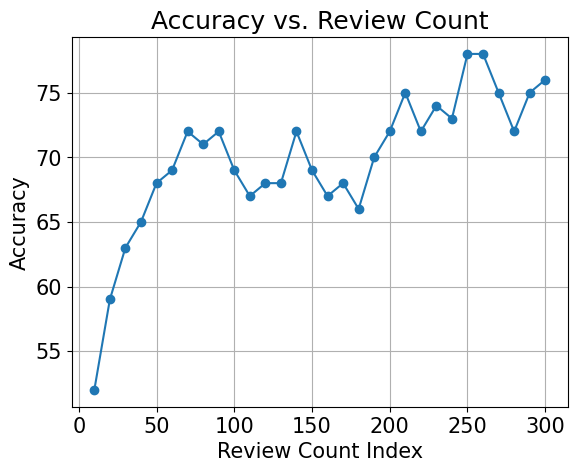

In [114]:
plt.plot(review_count_index, accuracy, marker='o', linestyle='-')
plt.title('Accuracy vs. Review Count')
plt.xlabel('Review Count Index')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()